In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from collections import Counter
from torch.optim import Adam
from transformers import BartTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, matthews_corrcoef, roc_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# __Read the Data__

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
structured_df = pd.read_csv("structured_data.csv")
structured_df = structured_df.drop(columns=['subject_id', 'diagnosis'])

unstructured_df = pd.read_csv("unstructured_data.csv")
unstructured_df = unstructured_df.drop(columns=['text', 'description'])

In [ ]:
structured_df.head()

hadm_id gender  age_at_admission  in_hospital_timedays  \
0   100335      M                86                    10   
1   100848      M                73                    12   
2   101384      F                73                     7   
3   101708      M                76                     6   
4   102432      M                83                    12   

               ethnicity  hospital_expire_flag  ABI_L_  ABI_R_  \
0                  WHITE                     0     NaN     NaN   
1  UNKNOWN/NOT SPECIFIED                     0     NaN     NaN   
2                  WHITE                     0     NaN     NaN   
3                  WHITE                     1     NaN     NaN   
4  UNKNOWN/NOT SPECIFIED                     0     NaN     NaN   

   ABI_Ankle_BP_Left_mmHg  ABI_Ankle_BP_Right_mmHg  ...  WBC,_Pleural_#/uL  \
0                     NaN                      NaN  ...                NaN   
1                     NaN                      NaN  ...                NaN   
2                     NaN                      NaN  ...                NaN   
3                     NaN                      NaN  ...                NaN   
4                     NaN                      NaN  ...                NaN   

   White_Blood_Cells_K/uL  Young_Cells_%  pCO2_MM_HG  pCO2_mm_Hg  pH_UNITS  \
0                     8.6            NaN         NaN        31.0       NaN   
1                     6.3            NaN         NaN        46.0       NaN   
2                    10.0            NaN         NaN        45.0       NaN   
3                     7.0            NaN         NaN        54.0       NaN   
4                     8.1            NaN        37.0         NaN      7.44   

   pH_units  pO2_MM_HG  pO2_mm_Hg  tacroFK_ng/mL  
0      7.34        NaN       91.0            NaN  
1      7.38        NaN       38.0            NaN  
2      7.42        NaN       41.0            NaN  
3      7.28        NaN       55.0            NaN  
4      5.50       29.0        NaN            NaN  

[5 rows x 462 columns]

In [ ]:
structured_df.tail()

hadm_id gender  age_at_admission  in_hospital_timedays  \
227   199511      F                68                    30   
228   199646      M                86                    34   
229   199806      F                44                     8   
230   199964      F                59                    12   
231   199994      F                58                    10   

                  ethnicity  hospital_expire_flag  ABI_L_  ABI_R_  \
227  BLACK/AFRICAN AMERICAN                     1     NaN     NaN   
228                   WHITE                     1     NaN     NaN   
229                   WHITE                     0     NaN     NaN   
230  BLACK/AFRICAN AMERICAN                     0     NaN     NaN   
231                   WHITE                     0     NaN     NaN   

     ABI_Ankle_BP_Left_mmHg  ABI_Ankle_BP_Right_mmHg  ...  WBC,_Pleural_#/uL  \
227                     NaN                      NaN  ...                NaN   
228                     NaN                      NaN  ...                NaN   
229                     NaN                      NaN  ...                NaN   
230                     NaN                      NaN  ...                NaN   
231                     NaN                      NaN  ...                NaN   

     White_Blood_Cells_K/uL  Young_Cells_%  pCO2_MM_HG  pCO2_mm_Hg  pH_UNITS  \
227                    18.0            NaN         NaN        33.0       NaN   
228                     7.6            NaN         NaN        37.0       NaN   
229                     3.2            NaN        31.0         NaN      7.38   
230                     7.3            NaN        20.0         NaN      7.41   
231                     6.7            NaN         NaN        52.0       NaN   

     pH_units  pO2_MM_HG  pO2_mm_Hg  tacroFK_ng/mL  
227      7.48        NaN       42.0            NaN  
228      5.00        NaN       73.0            NaN  
229      6.50      177.0        NaN            NaN  
230       NaN       52.0        NaN            NaN  
231      7.27        NaN      104.0            NaN  

[5 rows x 462 columns]

In [ ]:
unstructured_df.head()

hadm_id  hospital_expire_flag  \
0   108903                     1   
1   161464                     0   
2   132833                     0   
3   182341                     0   
4   184235                     0   

                                      processed_text  
0  sinus rhythm prolonged p r interval low voltag...  
1  atrio ventricular conduction delay p r interva...  
2  atrio ventricular conduction delay p r interva...  
3  sinus rhythm borderline first degree av block ...  
4  v sequential pacemaker compared previous traci...

In [ ]:
unstructured_df.tail()

hadm_id  hospital_expire_flag  \
25695   140789                     0   
25696   140789                     0   
25697   140789                     0   
25698   140789                     0   
25699   140789                     0   

                                          processed_text  
25695  wardname icu nursing admission note yo admitte...  
25696  esophagus clip clip number radiology reason eg...  
25697  chest portable ap clip clip number radiology r...  
25698  chest portable ap clip clip number radiology r...  
25699  pm urin cath replc clip clip number radiology ...

In [ ]:
structured_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Columns: 462 entries, hadm_id to tacroFK_ng/mL
dtypes: float64(445), int64(15), object(2)
memory usage: 837.5+ KB


In [ ]:
unstructured_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25700 entries, 0 to 25699
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   hadm_id               25700 non-null  int64 
 1   hospital_expire_flag  25700 non-null  int64 
 2   processed_text        25700 non-null  object
dtypes: int64(2), object(1)
memory usage: 602.5+ KB


# __Missing Data__

In [ ]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', ' Missing Percent'])
    return missing_data

missing_data = missing_percentage(structured_df)
missing_data

Total   Missing Percent
Cholesterol,_Pleural_mg/dL    232        100.000000
Factor_VII_%                  232        100.000000
Heparin,_LMW_U/mL             232        100.000000
Reptilase_Time_sec            231         99.568966
Protein_C,_Functional_%       231         99.568966
...                           ...               ...
Urea_Nitrogen_mg/dL             0          0.000000
Temperature_F_Deg_F             0          0.000000
calprevflg_kg                   0          0.000000
index                           0          0.000000
hadm_id                         0          0.000000

[462 rows x 2 columns]

In [ ]:
# Dropping fields which have more than 20% missing values

columns_to_drop = missing_data[missing_data[' Missing Percent'] > 20].index
structured_df = structured_df.drop(columns=columns_to_drop)
structured_df.head()

hadm_id gender  age_at_admission  in_hospital_timedays  \
0   100335      M                86                    10   
1   100848      M                73                    12   
2   101384      F                73                     7   
3   101708      M                76                     6   
4   102432      M                83                    12   

               ethnicity  hospital_expire_flag  Braden_Score_number  \
0                  WHITE                     0                  9.0   
1  UNKNOWN/NOT SPECIFIED                     0                 15.0   
2                  WHITE                     0                 12.0   
3                  WHITE                     1                 12.0   
4  UNKNOWN/NOT SPECIFIED                     0                 15.0   

   Calcium_84-102_mg/dl  GCS_Total_points  Heart_Rate_BPM  ...  PTT_sec  \
0                   8.7               7.0             104  ...     34.7   
1                   9.4              15.0              87  ...     35.4   
2                   7.5              13.0              80  ...     31.4   
3                   8.6              15.0              61  ...     33.9   
4                  10.0              15.0              79  ...     37.0   

   Phosphate_mg/dL  Platelet_Count_K/uL  Potassium_mEq/L  RDW_%  \
0              4.2                  116              5.1   15.2   
1              5.4                  121              4.6   18.3   
2              6.3                  238              4.2   18.0   
3              3.4                  171              4.7   18.1   
4              3.0                  215              3.6   17.7   

   Red_Blood_Cells_m/uL  Sodium_mEq/L  Urea_Nitrogen_mg/dL  \
0                  2.58           137                   87   
1                  2.84           137                   74   
2                  3.02           135                   24   
3                  3.64           137                   30   
4                  4.13           131                  115   

   White_Blood_Cells_K/uL  pH_units  
0                     8.6      7.34  
1                     6.3      7.38  
2                    10.0      7.42  
3                     7.0      7.28  
4                     8.1      5.50  

[5 rows x 56 columns]

In [ ]:
#collapsing ethnicity

structured_df['ethnicity'] = structured_df['ethnicity'].replace({
    'UNKNOWN/NOT SPECIFIED': 'UNKNOWN',
    'OTHER': 'UNKNOWN',
    'PATIENT DECLINED TO ANSWER': 'UNKNOWN'
})

In [ ]:
# Finding class balance for target variable

struct = structured_df['hospital_expire_flag'].value_counts()
unstruct = unstructured_df['hospital_expire_flag'].value_counts()

print(struct)
print(unstruct)

hospital_expire_flag
0    176
1     56
Name: count, dtype: int64
hospital_expire_flag
0    20958
1     4742
Name: count, dtype: int64


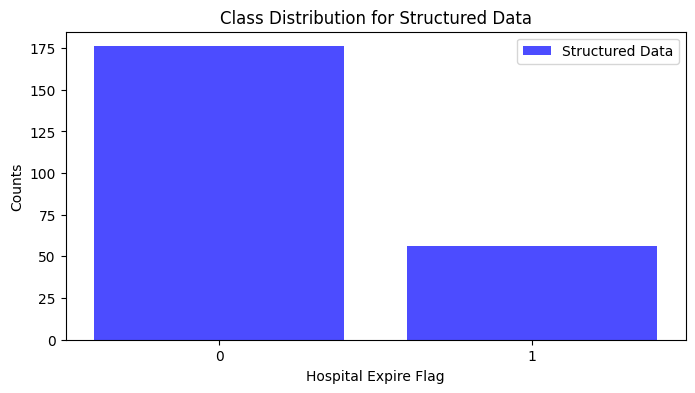

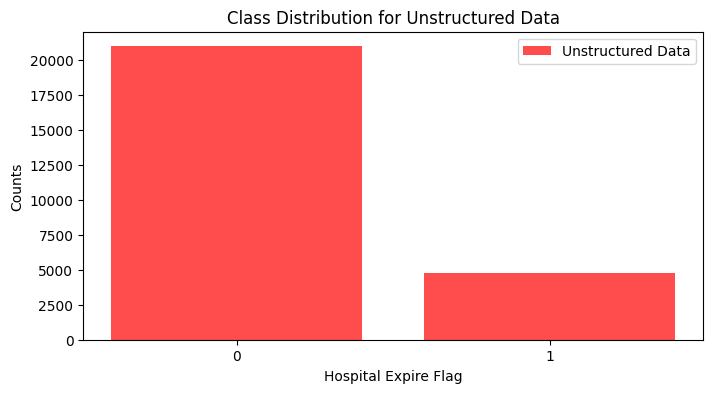

In [ ]:
struct = structured_df['hospital_expire_flag'].value_counts().sort_index()
unstruct = unstructured_df['hospital_expire_flag'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(struct.index, struct.values, color='blue', alpha=0.7, label='Structured Data')
plt.xlabel('Hospital Expire Flag')
plt.ylabel('Counts')
plt.title('Class Distribution for Structured Data')
plt.xticks(struct.index)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(unstruct.index, unstruct.values, color='red', alpha=0.7, label='Unstructured Data')
plt.xlabel('Hospital Expire Flag')
plt.ylabel('Counts')
plt.title('Class Distribution for Unstructured Data')
plt.xticks(unstruct.index)
plt.legend()
plt.show()

# __Categorical and Continuous Features__

In [ ]:
numeric = ['age_at_admission', 'in_hospital_timedays', 'Braden_Score_number', 'Calcium_84-102_mg/dl', 'GCS_Total_points', 'Heart_Rate_BPM', 'Hematocrit_%_x', 'Hemoglobin_gm/dl',
           'NBP_Mean_mmHg', 'NBP_Diastolic_mmHg', 'NBP_Systolic_mmHg', 'O2_Flow_lpm_lpm', 'Phosphorous27-45_mEq/L', 'RBC_/mic_l', 'Respiratory_Rate_BPM', 'SpO2_%', 'Temperature_C_calc_Deg_C', 'Temperature_F_Deg_F',
           'calprevflg_kg', 'index', 'Alanine_Aminotransferase_ALT_IU/L', 'Albumin_g/dL', 'Anion_Gap_mEq/L', 'Asparate_Aminotransferase_AST_IU/L', 'Base_Excess_mEq/L', 'Basophils_%', 'Bicarbonate_mEq/L',
           'Bilirubin,_Total_mg/dL', 'Calcium,_Total_mg/dL', 'Chloride_mEq/L', 'Creatinine_mg/dL', 'Eosinophils_%', 'Glucose_mg/dL', 'Hematocrit_%_y', 'Hemoglobin_g/dL', 'Lymphocytes_%', 'MCH_pg', 'MCHC_%', 'MCV_fL',
           'Magnesium_mg/dL', 'Monocytes_%', 'Neutrophils_%', 'PTT_sec', 'Phosphate_mg/dL', 'Platelet_Count_K/uL', 'Potassium_mEq/L', 'RDW_%', 'Red_Blood_Cells_m/uL', 'Sodium_mEq/L', 'Urea_Nitrogen_mg/dL',
           'White_Blood_Cells_K/uL', 'pH_units']

In [ ]:
categorical= ['gender', 'ethnicity']

# __EDA__

In [ ]:
numeric_summary = structured_df[numeric].describe()
print(numeric_summary)

       age_at_admission  in_hospital_timedays  Braden_Score_number  \
count        232.000000            232.000000           230.000000   
mean          64.051724             13.836207            14.147826   
std           13.599303             13.488134             2.749334   
min           26.000000              0.000000             7.000000   
25%           54.000000              6.000000            12.000000   
50%           64.000000             10.000000            14.000000   
75%           75.250000             17.250000            16.000000   
max           88.000000             87.000000            23.000000   

       Calcium_84-102_mg/dl  GCS_Total_points  Heart_Rate_BPM  Hematocrit_%_x  \
count            220.000000        231.000000      232.000000      229.000000   
mean               8.525909         12.822511       81.879310       30.799127   
std                0.883699          3.295401       16.058688        4.069775   
min                5.600000          3.000000

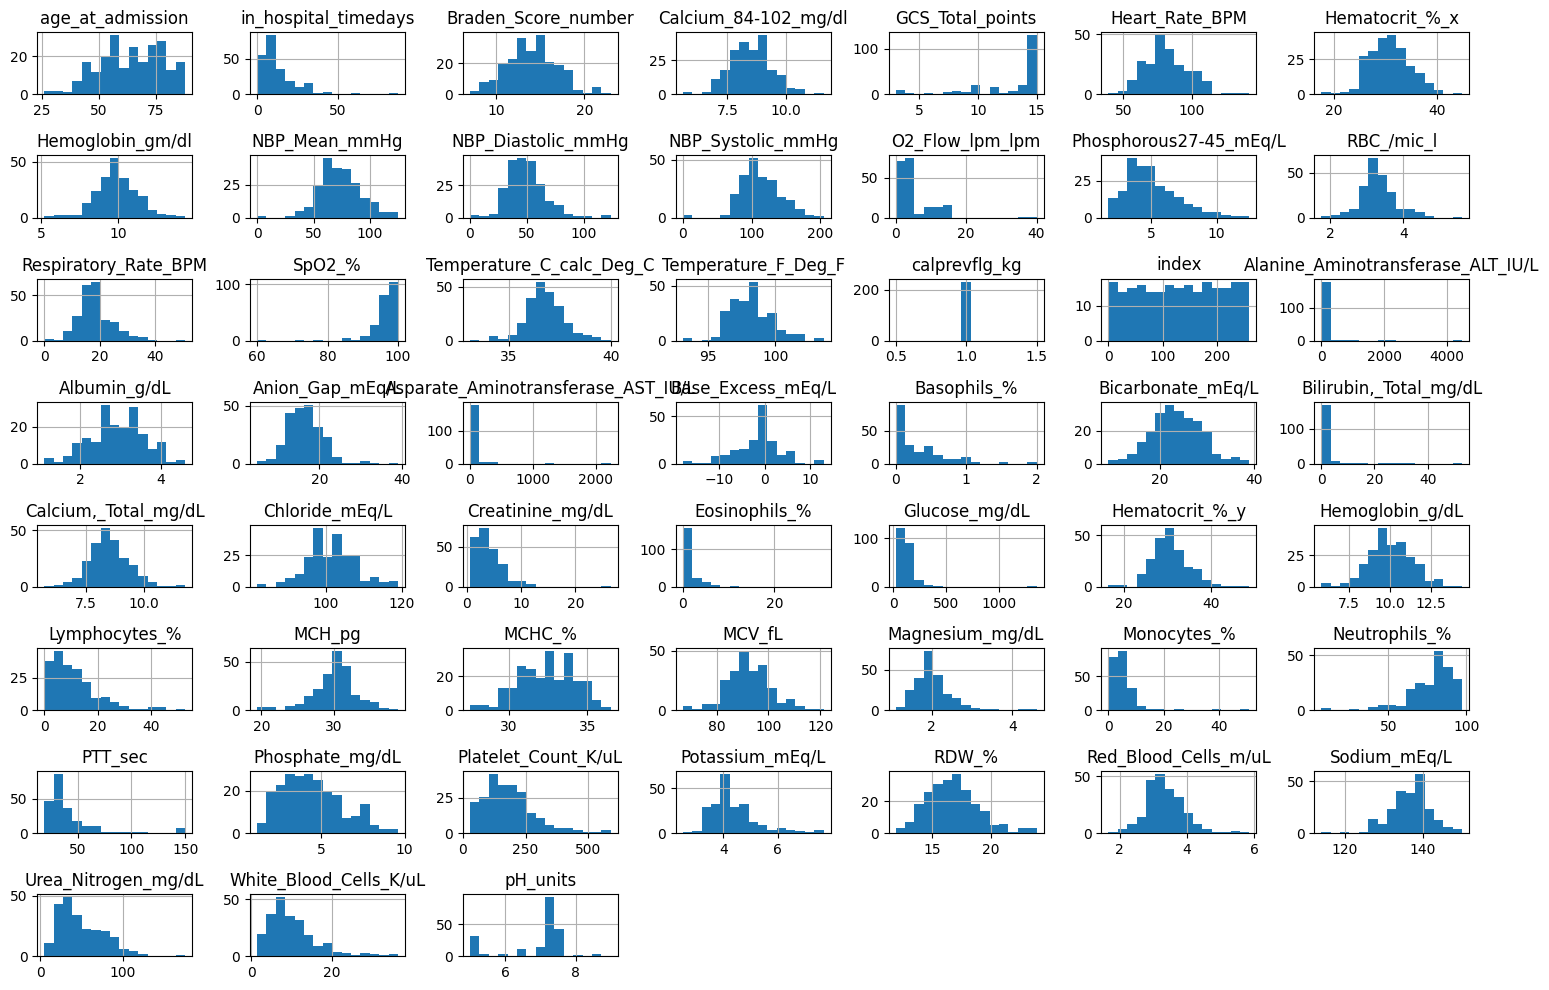

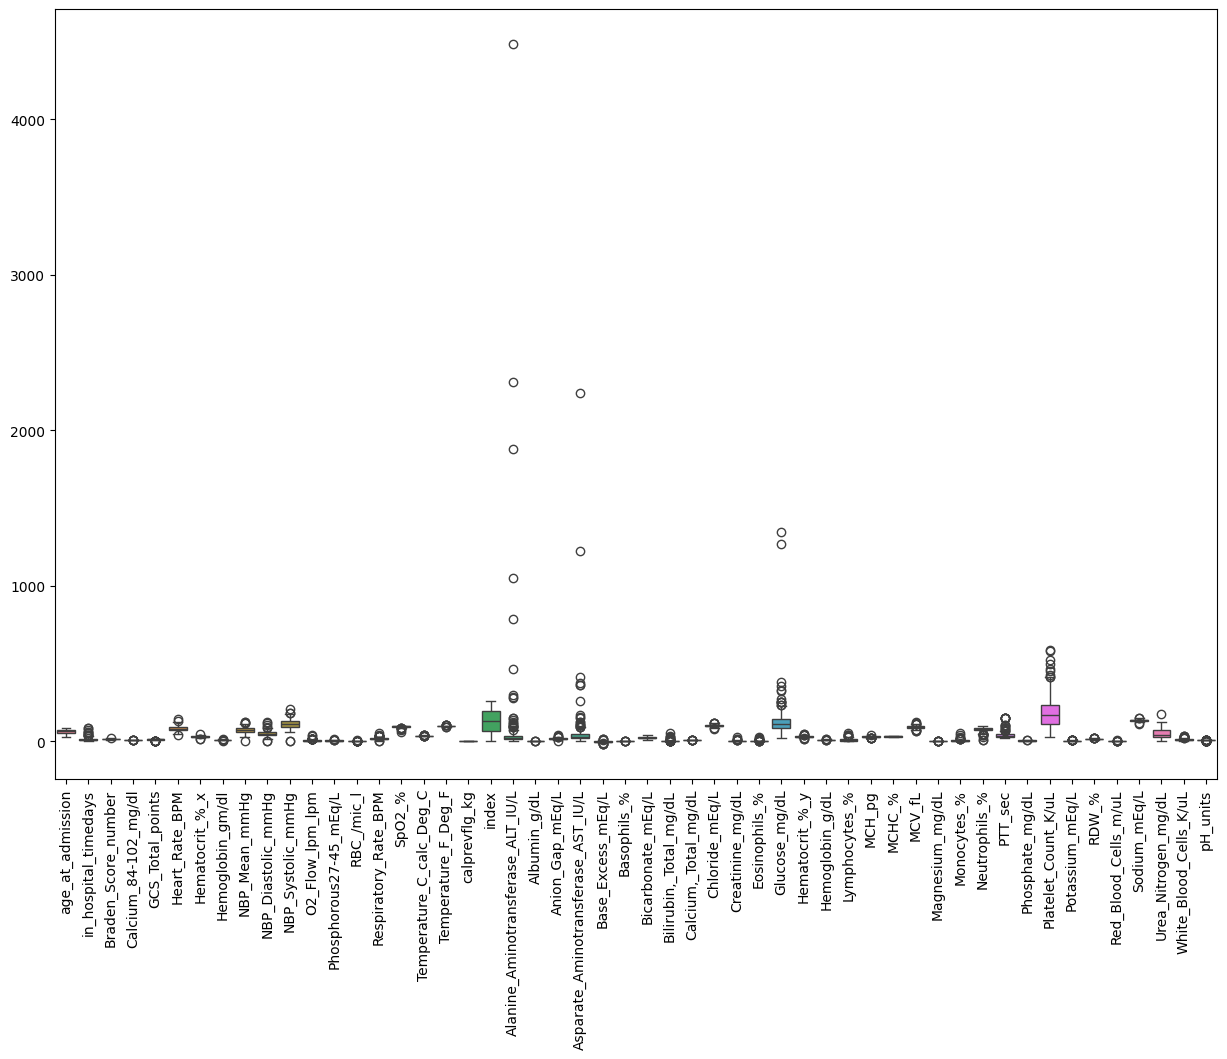

In [ ]:
structured_df[numeric].hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=structured_df[numeric])
plt.xticks(rotation=90)
plt.show()

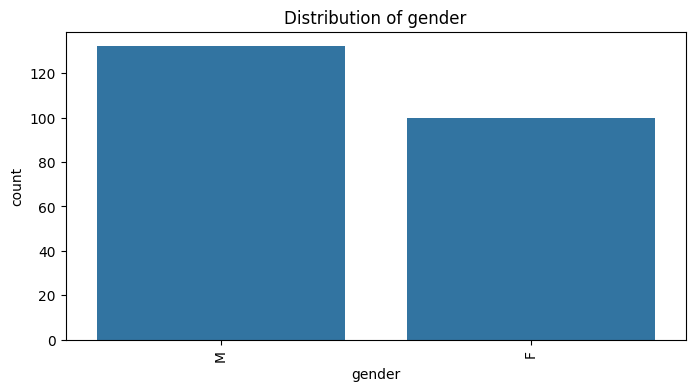

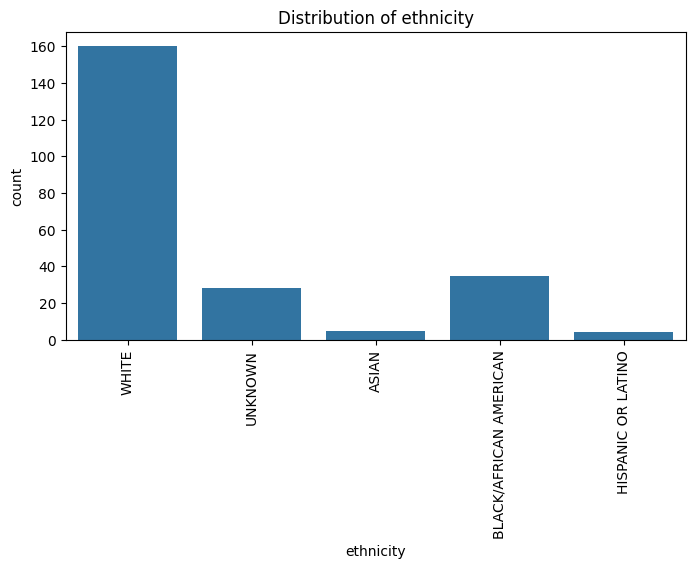

In [ ]:
for category in categorical:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=structured_df, x=category)
    plt.title(f'Distribution of {category}')
    plt.xticks(rotation=90)
    plt.show()

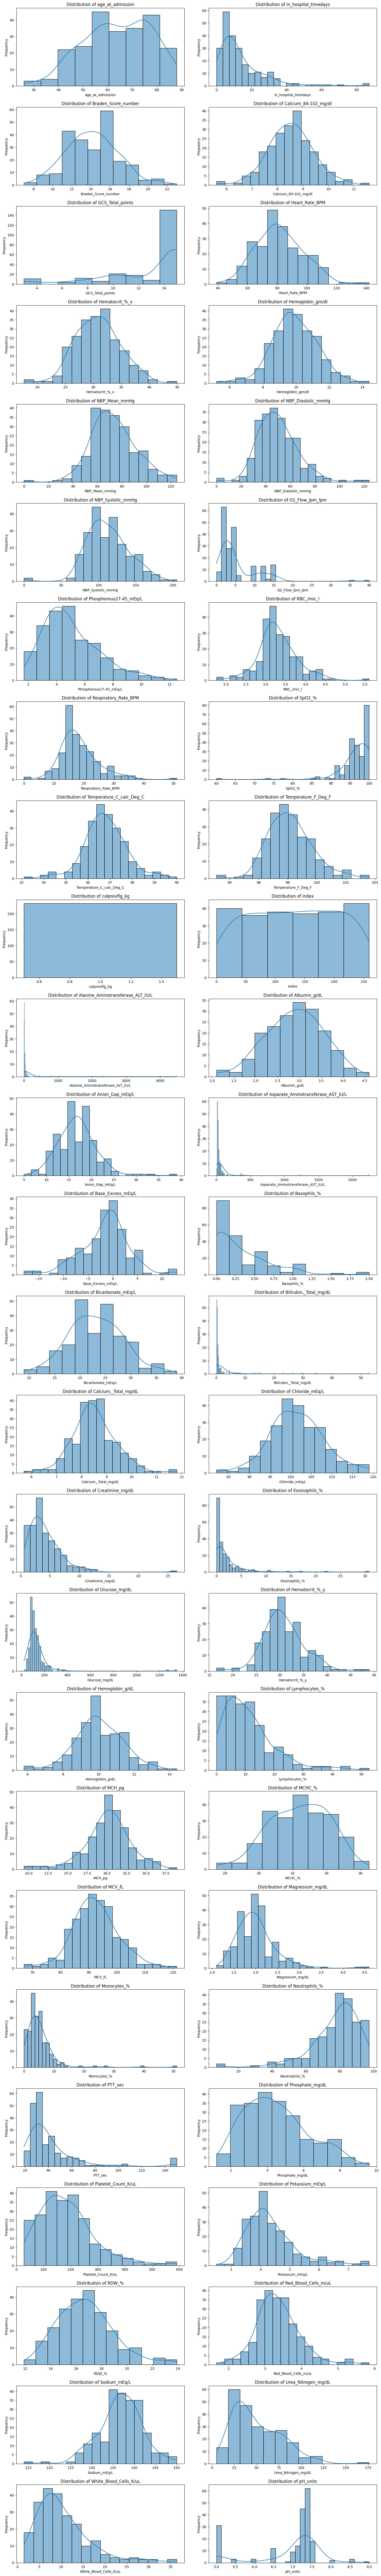

In [ ]:
def histo(df, columns):
    ncols = 2
    nrows = int(np.ceil(len(columns) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows))
    plt.tight_layout(pad=4.0)
    axes = axes.flatten()

    for ax, col in zip(axes, columns):
        series_without_na = df[col].dropna()
        if series_without_na.empty:
            ax.set_title(f'Distribution of {col} (No Data)')
            ax.set_visible(False)
            continue
        unique_values = series_without_na.nunique()
        if unique_values == 1:
            bins = 1
        else:
            q1, q3 = np.percentile(series_without_na, [25, 75])
            iqr = q3 - q1
            if iqr == 0:
                bins = 1
            else:
                bin_width = 2 * iqr * (len(series_without_na) ** (-1/3))
                bins = int(np.round((series_without_na.max() - series_without_na.min()) / bin_width))

        sns.histplot(series_without_na, bins=bins, kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)

histo(structured_df, numeric)

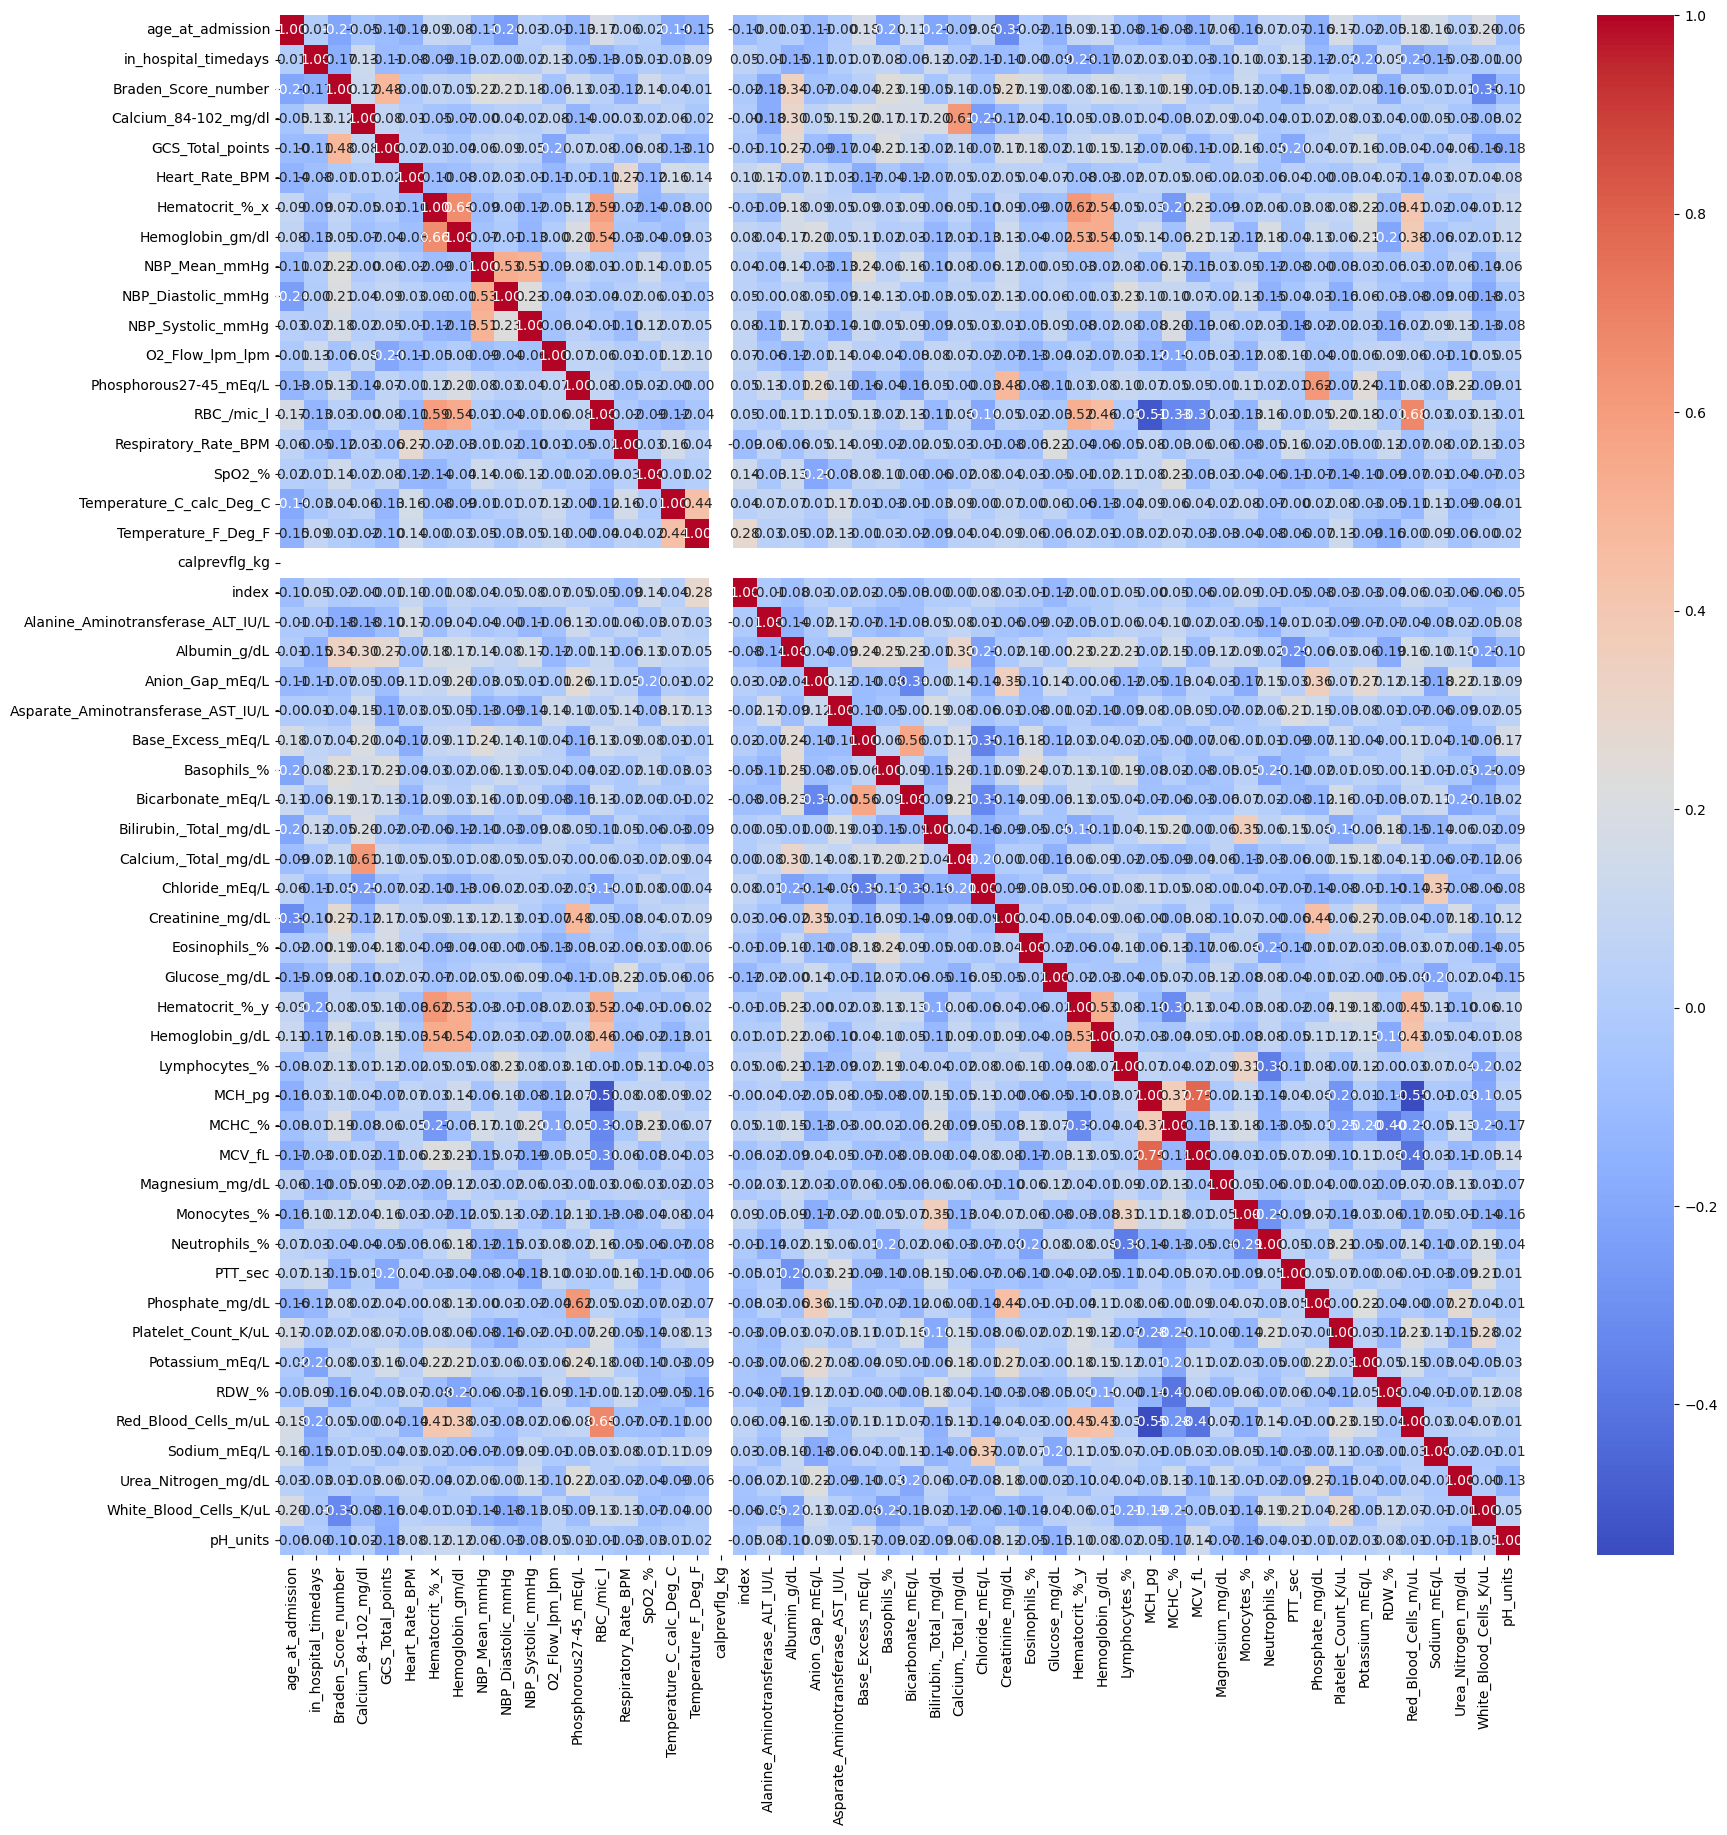

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(structured_df[numeric].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

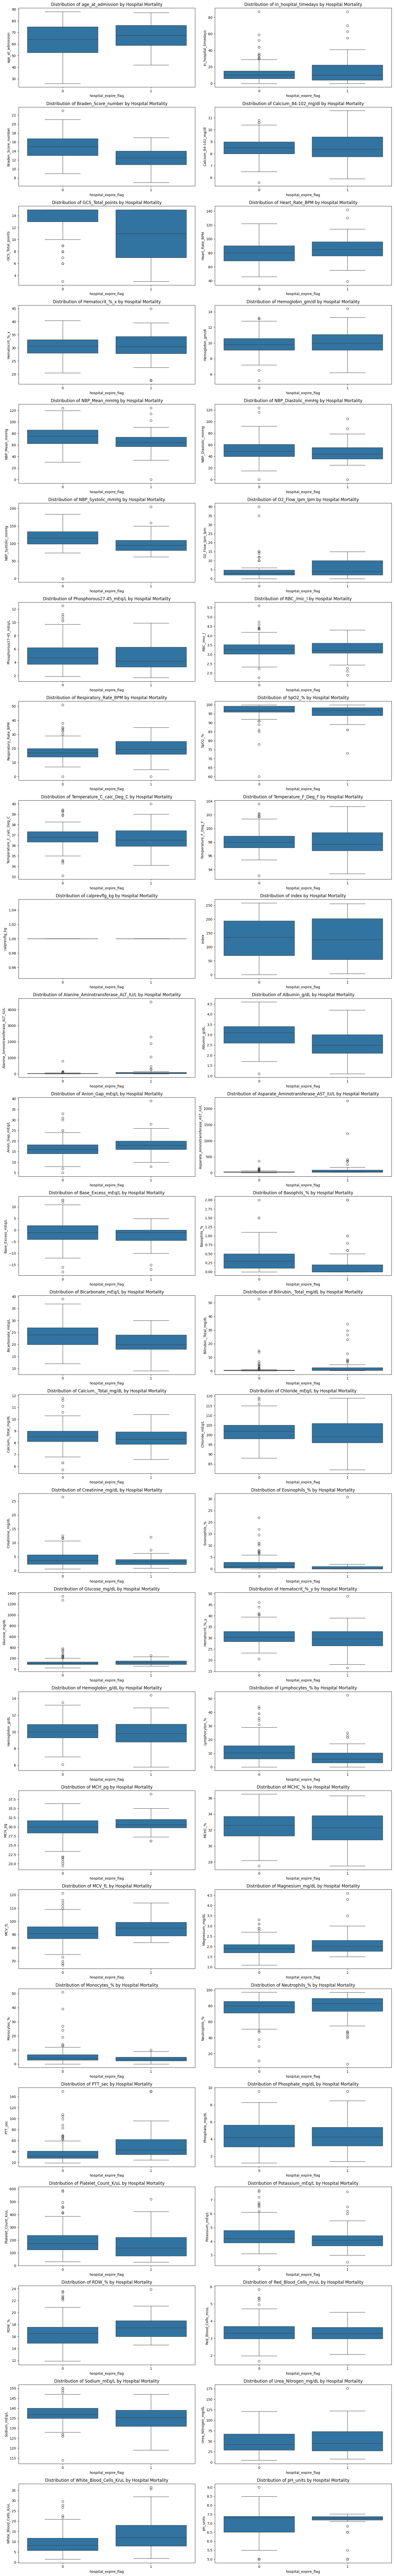

In [ ]:
nrows = (len(numeric) + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 4 * nrows))

axes = axes.flatten()

for i, var in enumerate(numeric):
    sns.boxplot(x='hospital_expire_flag', y=var, data=structured_df, ax=axes[i])
    axes[i].set_title(f'Distribution of {var} by Hospital Mortality')

if len(numeric) % 2 != 0:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# __Mutual Information__

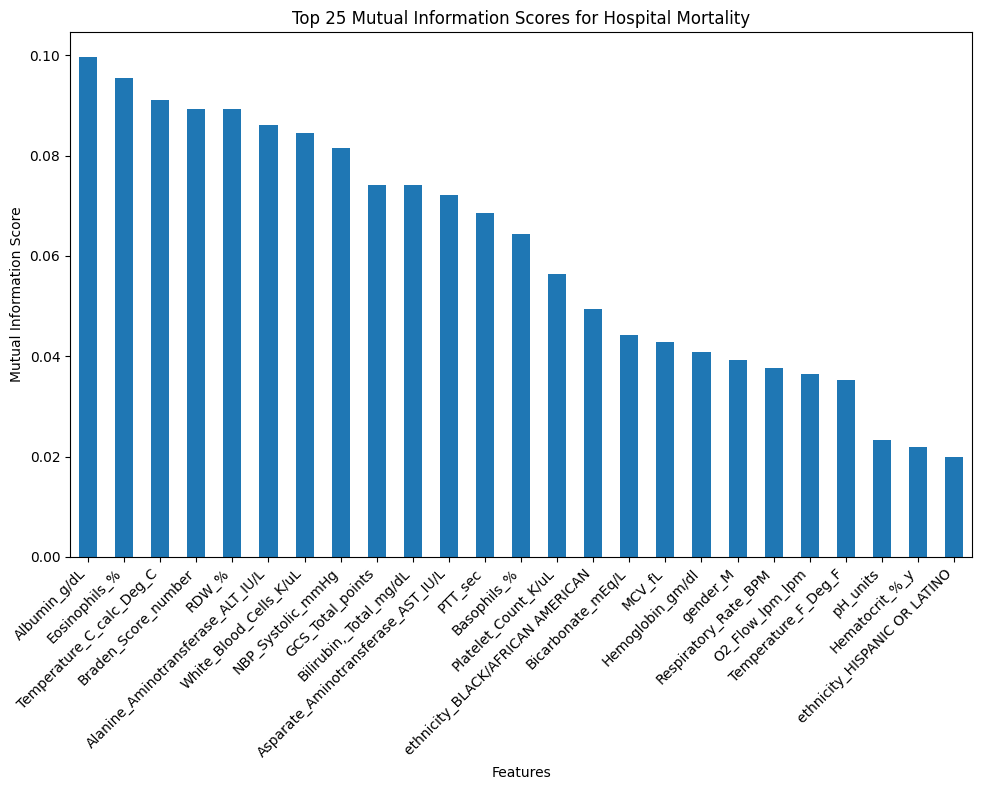

In [ ]:
X = structured_df.drop(['hospital_expire_flag'], axis=1)  # Features
y = structured_df['hospital_expire_flag']  # Target variable

X_encoded = pd.get_dummies(X, drop_first=True)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)
X_imputed_df = pd.DataFrame(X_imputed, columns=X_encoded.columns)

result = mutual_info_classif(X_imputed_df, y, discrete_features='auto')
mi_scores = pd.Series(result, index=X_imputed_df.columns, name="MI Scores").sort_values(ascending=False)

plt.figure(figsize=(10, 8))
mi_scores.head(25).plot(kind='bar')
plt.title('Top 25 Mutual Information Scores for Hospital Mortality')
plt.ylabel('Mutual Information Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# __Model 1__: LSTM

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from collections import Counter
from torch.optim import Adam

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical)])

X_processed = preprocessor.fit_transform(structured_df)
y = structured_df['hospital_expire_flag'].values

X_train_struct, X_test_struct, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
def build_vocab(texts):
    token_counter = Counter(word for text in texts for word in text.split())
    vocab = {word: i + 1 for i, word in enumerate(token_counter)}
    vocab['<pad>'] = 0
    return vocab

vocab = build_vocab(unstructured_df['processed_text'].tolist())

def text_to_sequence(texts, vocab, seq_length):
    sequences = []
    for text in texts:
        sequence = [vocab[word] for word in text.split() if word in vocab]
        padded_sequence = sequence + [vocab['<pad>']] * (seq_length - len(sequence))
        sequences.append(padded_sequence)
    return sequences

max_seq_length = max(len(text.split()) for text in unstructured_df['processed_text'])
padded_texts = text_to_sequence(unstructured_df['processed_text'].tolist(), vocab, max_seq_length)

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, structured_data, text_data, labels):
        self.structured_data = structured_data
        self.text_data = text_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'structured_data': torch.tensor(self.structured_data[idx], dtype=torch.float),
            'text': torch.tensor(self.text_data[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = MultimodalDataset(X_train_struct, padded_texts, y_train)
test_dataset = MultimodalDataset(X_test_struct, padded_texts, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        return lstm_out[:, -1, :]  # last hidden state

class StructuredNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StructuredNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.relu(self.fc1(x))

class MultimodalNN(nn.Module):
    def __init__(self, structured_model, text_model, structured_output_dim, lstm_output_dim):
        super(MultimodalNN, self).__init__()
        self.structured_model = structured_model
        self.text_model = text_model
        self.classifier = nn.Linear(structured_output_dim + lstm_output_dim, 1)

    def forward(self, structured_data, text_data):
        structured_output = self.structured_model(structured_data)
        text_output = self.text_model(text_data)
        combined = torch.cat((structured_output, text_output), dim=1)
        return torch.sigmoid(self.classifier(combined))

vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 50
structured_input_dim = X_train_struct.shape[1]
structured_output_dim = 50

structured_model = StructuredNN(structured_input_dim, structured_output_dim)
text_model = LSTMModel(vocab_size, embedding_dim, hidden_dim)
model = MultimodalNN(structured_model, text_model, structured_output_dim, hidden_dim)

In [ ]:
def train_model(model, train_loader, optimizer, loss_function, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        structured_data = batch['structured_data'].to(device)
        text_data = batch['text'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        predictions = model(structured_data, text_data).squeeze(1)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

optimizer = Adam(model.parameters(), lr=0.001)
loss_function = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(75):  # number of epochs
    loss = train_model(model, train_loader, optimizer, loss_function, device)
    print(f'Epoch {epoch + 1}: Loss = {loss:.4f}')

Epoch 1: Loss = 0.6458
Epoch 2: Loss = 0.5343
Epoch 3: Loss = 0.5057
Epoch 4: Loss = 0.4877
Epoch 5: Loss = 0.4799
Epoch 6: Loss = 0.4544
Epoch 7: Loss = 0.4372
Epoch 8: Loss = 0.4150
Epoch 9: Loss = 0.3938
Epoch 10: Loss = 0.3729
Epoch 11: Loss = 0.3498
Epoch 12: Loss = 0.3293
Epoch 13: Loss = 0.3159
Epoch 14: Loss = 0.2916
Epoch 15: Loss = 0.2766
Epoch 16: Loss = 0.2606
Epoch 17: Loss = 0.2423
Epoch 18: Loss = 0.2280
Epoch 19: Loss = 0.2173
Epoch 20: Loss = 0.2046
Epoch 21: Loss = 0.1979
Epoch 22: Loss = 0.1840
Epoch 23: Loss = 0.1730
Epoch 24: Loss = 0.1679
Epoch 25: Loss = 0.1601
Epoch 26: Loss = 0.1508
Epoch 27: Loss = 0.1466
Epoch 28: Loss = 0.1383
Epoch 29: Loss = 0.1305
Epoch 30: Loss = 0.1290
Epoch 31: Loss = 0.1236
Epoch 32: Loss = 0.1166
Epoch 33: Loss = 0.1112
Epoch 34: Loss = 0.1084
Epoch 35: Loss = 0.1014
Epoch 36: Loss = 0.0988
Epoch 37: Loss = 0.0966
Epoch 38: Loss = 0.0922
Epoch 39: Loss = 0.0889
Epoch 40: Loss = 0.0858
Epoch 41: Loss = 0.0818
Epoch 42: Loss = 0.0794
E

Accuracy: 0.7872
Precision: 0.7778
Recall: 0.4667
F1 Score: 0.5833
AUC Score: 0.8063
MCC Score: 0.4788


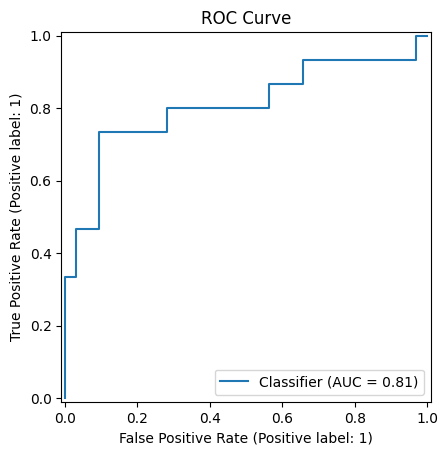

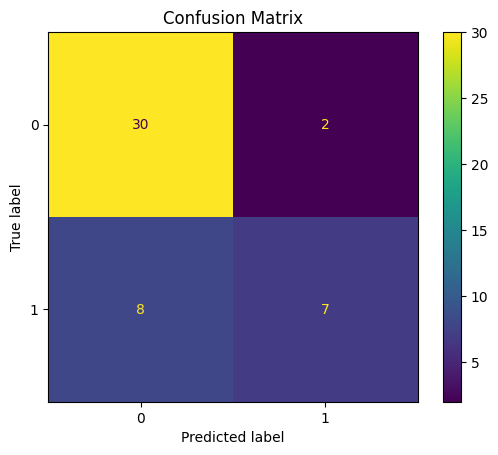

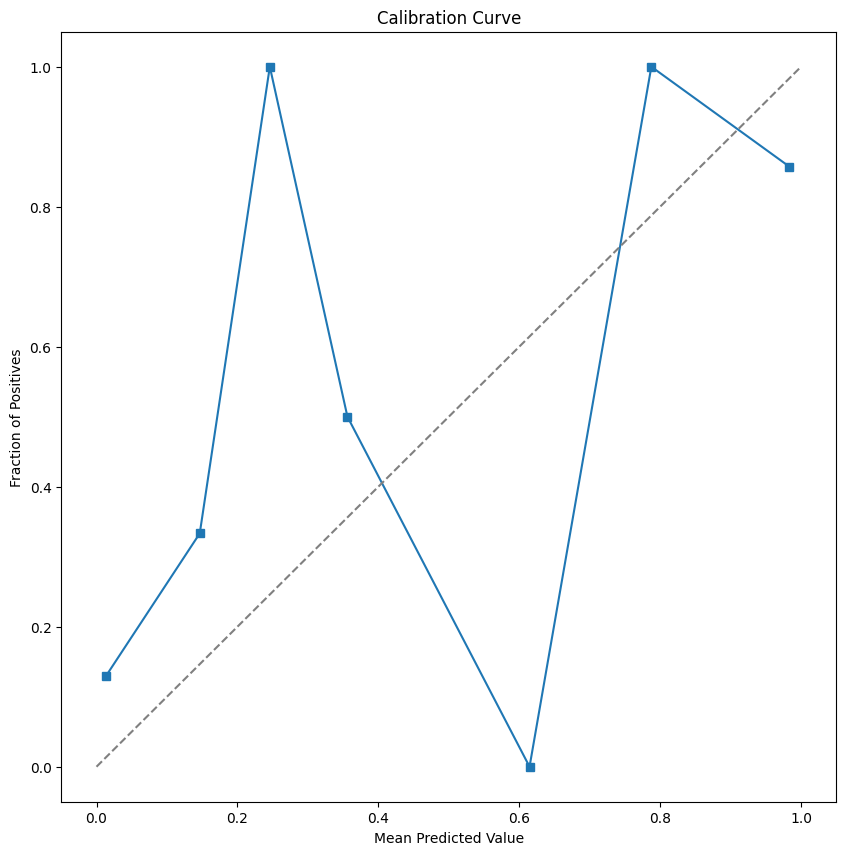

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix
)
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_true_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in test_loader:
            structured_data = batch['structured_data'].to(device)
            text_data = batch['text'].to(device)
            labels = batch['label'].to(device)

            outputs = model(structured_data, text_data).squeeze(1)
            predicted_labels = (outputs > 0.5).float()
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())

    # Calculating various metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)
    auc = roc_auc_score(all_true_labels, all_probabilities)
    mcc = matthews_corrcoef(all_true_labels, all_predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"MCC Score: {mcc:.4f}")

    # ROC Curve
    RocCurveDisplay.from_predictions(all_true_labels, all_probabilities)
    plt.title('ROC Curve')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()
    plt.title('Confusion Matrix')
    plt.show()

    # Calibration Curve
    fraction_of_positives, mean_predicted_value = calibration_curve(all_true_labels, all_probabilities, n_bins=10)
    plt.figure(figsize=(10, 10))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title('Calibration Curve')
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.show()

# Call the evaluate function
evaluate_model(model, test_loader, device)

# __Model 2__ : Transformer BART

In [ ]:
df = pd.merge(structured_df, unstructured_df, on='hadm_id')

In [ ]:
df = df.drop(columns=['hospital_expire_flag_y'])
df = df.rename(columns={'hospital_expire_flag_x': 'hospital_expire_flag'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23025 entries, 0 to 23024
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   hadm_id                             23025 non-null  int64  
 1   gender                              23025 non-null  object 
 2   age_at_admission                    23025 non-null  int64  
 3   in_hospital_timedays                23025 non-null  int64  
 4   ethnicity                           23025 non-null  object 
 5   hospital_expire_flag                23025 non-null  int64  
 6   Braden_Score_number                 22957 non-null  float64
 7   Calcium_84-102_mg/dl                22458 non-null  float64
 8   GCS_Total_points                    23013 non-null  float64
 9   Heart_Rate_BPM                      23025 non-null  int64  
 10  Hematocrit_%_x                      22745 non-null  float64
 11  Hemoglobin_gm/dl                    22584

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from transformers import BartTokenizer
from torch.utils.data import Dataset, DataLoader
import torch


# Transformer for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor for column transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical)
    ])

# Apply transformations
X_structured = preprocessor.fit_transform(df.drop(['hospital_expire_flag', 'hadm_id', 'processed_text'], axis=1))
y = df['hospital_expire_flag'].values

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

class TextAndTabularDataset(Dataset):
    def __init__(self, texts, structured_data, labels):
        self.texts = texts
        self.structured_data = structured_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=512, return_tensors="pt")
        structured_data = torch.tensor(self.structured_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {**encoding, 'structured_data': structured_data, 'labels': label}

# Split data
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_structured, test_structured, train_labels, test_labels = train_test_split(
    df['processed_text'].tolist(), X_structured, y, test_size=0.2, random_state=42)

train_dataset = TextAndTabularDataset(train_texts, train_structured, train_labels)
test_dataset = TextAndTabularDataset(test_texts, test_structured, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
from transformers import BartModel
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, num_structured_features):
        super(HybridModel, self).__init__()
        self.bart = BartModel.from_pretrained('facebook/bart-base')
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.bart.config.hidden_size + num_structured_features, 2)
        )

    def forward(self, input_ids, attention_mask, structured_data):
        outputs = self.bart(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # We use the first token (similar to BERT's [CLS])
        concat_output = torch.cat((pooled_output, structured_data), dim=1)
        logits = self.classifier(concat_output)
        return logits

In [ ]:
from tqdm import tqdm
import torch.nn as nn
from transformers import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(train_structured.shape[1]).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc='Training Epoch Progress'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        structured_data = batch['structured_data'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask, structured_data)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(3):
    loss = train(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}, Loss: {loss}")

/home/nb752/.conda/envs/myenv/lib/python3.12/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch Progress: 100%|██████████| 1152/1152 [21:45<00:00,  1.13s/it]


Epoch 1, Loss: 0.4421862603145807


Training Epoch Progress: 100%|██████████| 1152/1152 [21:43<00:00,  1.13s/it]


Epoch 2, Loss: 0.2919107342604548


Training Epoch Progress: 100%|██████████| 1152/1152 [21:43<00:00,  1.13s/it]

Epoch 3, Loss: 0.20975828219282752


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, matthews_corrcoef, roc_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

def evaluate(model, loader, device):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask = batch['attention_mask'].squeeze(1).to(device)
            structured_data = batch['structured_data'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, structured_data)
            logits = outputs
            predicted_labels = torch.argmax(logits, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probs = torch.nn.functional.softmax(logits, dim=1)[:, 1]  # Probability for class 1
            probabilities.extend(probs.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    auc = roc_auc_score(true_labels, probabilities)
    mcc = matthews_corrcoef(true_labels, predictions)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot calibration curve
    prob_true, prob_pred = calibration_curve(true_labels, probabilities, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration plot')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('True probability in each bin')
    plt.legend()
    plt.title('Calibration Curve')
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "mcc": mcc
    }

Evaluating: 100%|██████████| 288/288 [01:51<00:00,  2.59it/s]


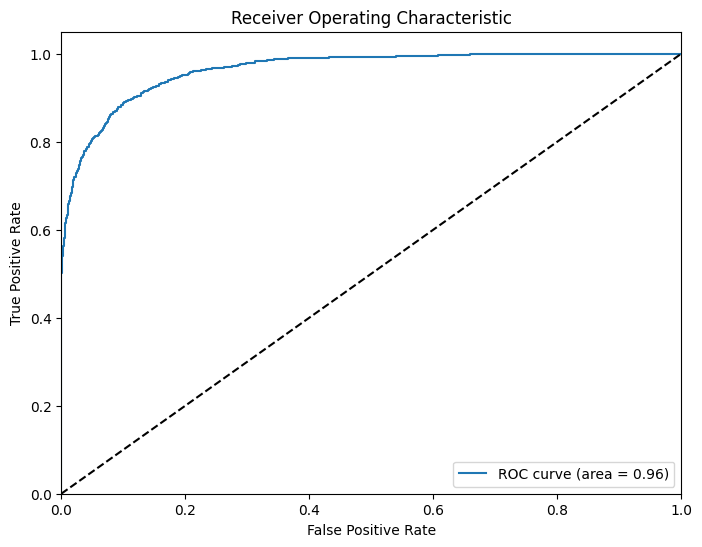

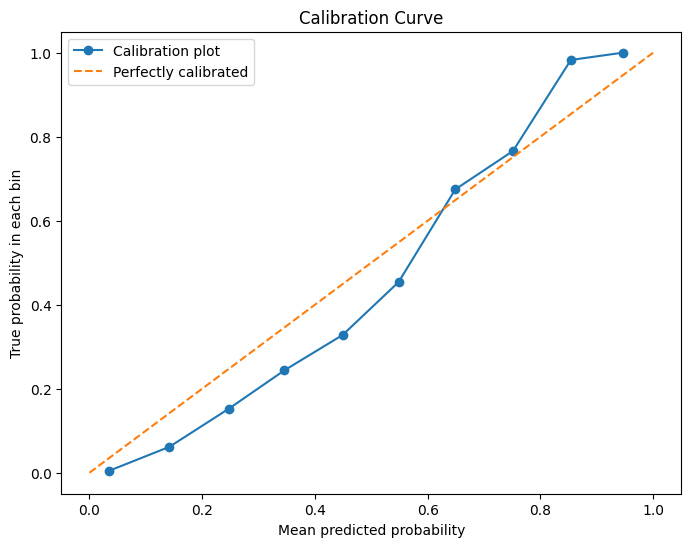

Evaluation metrics: {'accuracy': 0.9237785016286645, 'precision': 0.835990888382688, 'recall': 0.7800212539851222, 'f1': 0.8070368334249588, 'auc': 0.9636205328346226, 'mcc': 0.7603256258542894}


In [ ]:
metrics = evaluate(model, test_loader, device)
print("Evaluation metrics:", metrics)